In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
dir_path = "../data/"

# Utils

In [3]:
from sklearn.metrics import mean_squared_error

def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files



def run_tests(dir_path, method, verbose=0):
    
    if verbose > 0: print("Dataset: ", dir_path)
    # get list of files in dataset
    files = get_files_list(dir_path)
    files.sort()
    
    # fataframe for quality metrics
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    # run test on each file
    for afile in files:
        
        if verbose > 0: print("File: ", afile)
            
        # read data
        data = pd.read_csv(afile, index_col=False)
        
        # prepare signal with outliers (X) and clean true signal (X_true)
        X      = data['X'].values
        X_true = data['Truth'].values
        
        # run outliers removal algorithm
        X_clean = method(X)
        
        # compute quality
        mse = mean_squared_error(X_true, X_clean)
        rmse = np.sqrt(mse)
        
        # collect metric
        report.loc[len(report)] = [afile, rmse]
        if verbose > 0:
            print("RMSE: ", rmse)
            
    return report

# Visual Inspection

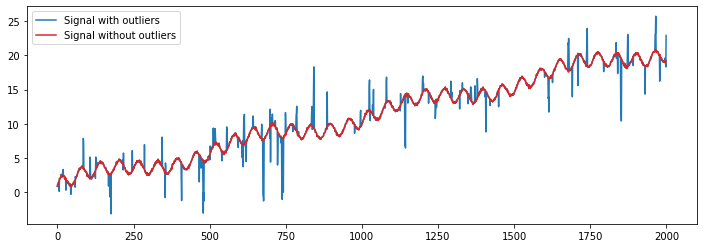

In [4]:
data = pd.read_csv("../data/sample5.csv", index_col=False)

# prepare signal with outliers (X) and clean true signal (X_true)
X_sig  = data['X'].values
X_true = data['Truth'].values

plt.figure(figsize=(12, 4))
plt.plot(X_sig, color='C0', alpha=0.99, label='Signal with outliers')
plt.plot(X_true, color='C3', alpha=0.99, label='Signal without outliers')
plt.legend(loc='best')
plt.show()

# Задание:

Есть сигнал с выбросами (колонка `X`). Нужно обнаружить выбросы и удалить из данных, заменив их более подходящими значениями. Результат сравнивается с чистым сигналом (колонка `Truth`) метрикой RMSE.

# Baseline 1

In [5]:
def baseline1(X):
    """
    No outliers removal.
    """
    return X

In [6]:
report_baselin1 = run_tests(dir_path, method=baseline1, verbose=1)
report_baselin1

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.9980460651654097
File:  ../data/sample2.csv
RMSE:  0.8896078503354946
File:  ../data/sample3.csv
RMSE:  0.955692309883414
File:  ../data/sample4.csv
RMSE:  1.0769149530674085
File:  ../data/sample5.csv
RMSE:  1.047075581043189
File:  ../data/sample6.csv
RMSE:  24.143009041233995
File:  ../data/sample7.csv
RMSE:  43.32314355387681
File:  ../data/sample8.csv
RMSE:  3.9132444147231604
File:  ../data/sample9.csv
RMSE:  527.0531164664669


Sample        RMSE
0  ../data/sample1.csv    0.998046
1  ../data/sample2.csv    0.889608
2  ../data/sample3.csv    0.955692
3  ../data/sample4.csv    1.076915
4  ../data/sample5.csv    1.047076
5  ../data/sample6.csv   24.143009
6  ../data/sample7.csv   43.323144
7  ../data/sample8.csv    3.913244
8  ../data/sample9.csv  527.053116

# Baseline 2

In [7]:
def SMA(scores, N):
    new_scores = []
    for i in range(0, len(scores)):
        s = i - N if i - N >= 0 else 0
        new_scores.append(np.mean(scores[s:i+1], axis=0))
    return np.array(new_scores)


def baseline2(X):
    """
    Using moving average.
    """
    X_smooth = SMA(X, 20)
    res = np.abs(X - X_smooth)
    thr = np.percentile(res, 95)
    inds = np.arange(len(X))
    out_inds = inds[res > thr]
    X_clean = X.copy()
    X_clean[out_inds] = X_smooth[out_inds]
    return X_clean

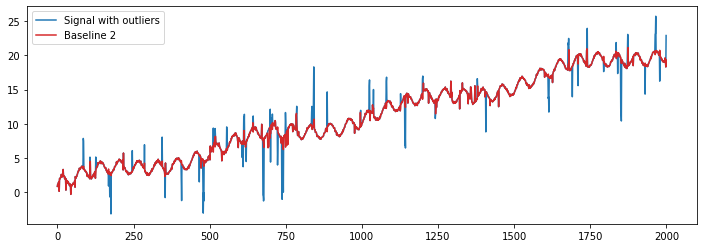

In [8]:
data = pd.read_csv("../data/sample5.csv", index_col=False)

# prepare signal with outliers (X) and clean true signal (X_true)
X_sig  = data['X'].values
X_true = data['Truth'].values

# cleaning
X_clean = baseline2(X_sig)

plt.figure(figsize=(12, 4))
plt.plot(X_sig, color='C0', alpha=0.99, label='Signal with outliers')
plt.plot(X_clean, color='C3', alpha=0.99, label='Baseline 2')
plt.legend(loc='best')
plt.show()

In [9]:
report_baselin2 = run_tests(dir_path, method=baseline2, verbose=1)
report_baselin2

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.336675615986372
File:  ../data/sample2.csv
RMSE:  0.2887606913452918
File:  ../data/sample3.csv
RMSE:  0.36997350232817156
File:  ../data/sample4.csv
RMSE:  0.4048916914553176
File:  ../data/sample5.csv
RMSE:  0.3658901986807782
File:  ../data/sample6.csv
RMSE:  7.761159372250721
File:  ../data/sample7.csv
RMSE:  15.064275320489376
File:  ../data/sample8.csv
RMSE:  1.2377279400579266
File:  ../data/sample9.csv
RMSE:  175.2760728388696


Sample        RMSE
0  ../data/sample1.csv    0.336676
1  ../data/sample2.csv    0.288761
2  ../data/sample3.csv    0.369974
3  ../data/sample4.csv    0.404892
4  ../data/sample5.csv    0.365890
5  ../data/sample6.csv    7.761159
6  ../data/sample7.csv   15.064275
7  ../data/sample8.csv    1.237728
8  ../data/sample9.csv  175.276073

# Models Comparison

In [10]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['No', 'Baseline 1'] + list(report_baselin1['RMSE'].values)
board.loc[len(board)] = ['Moving average', 'Baseline 2'] + list(report_baselin2['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3   sample4   sample5  \
Data preparation Model                                                          
No               Baseline 1  0.998046  0.889608  0.955692  1.076915  1.047076   
Moving average   Baseline 2  0.336676  0.288761  0.369974  0.404892  0.365890   

                               sample6    sample7   sample8     sample9  
Data preparation Model                                                   
No               Baseline 1  24.143009  43.323144  3.913244  527.053116  
Moving average   Baseline 2   7.761159  15.064275  1.237728  175.276073

In [11]:
board.iloc[[0], :].to_csv('../results/baseline1.csv')
board.iloc[[1], :].to_csv('../results/baseline2.csv')